In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
interval_var = '5min'
symbol='BTC'

In [3]:
df = pd.read_csv('BTC_USD_210101_220101.csv')

In [4]:
# 2021.01.01 - 21.03.31
df = df[:25920]
df = df.reset_index()
print(df)

       index    <DATE>  <TIME>    <OPEN>    <HIGH>     <LOW>   <CLOSE>  <VOL>
0          0  20210101     500  29181.00  29192.69  29000.00  29032.43    199
1          1  20210101    1000  29030.13  29046.50  28946.22  29042.15     88
2          2  20210101    1500  29042.16  29088.00  29025.42  29088.00     43
3          3  20210101    2000  29087.99  29198.98  29081.51  29191.54     88
4          4  20210101    2500  29193.04  29198.73  29100.00  29129.63    116
...      ...       ...     ...       ...       ...       ...       ...    ...
25915  25915  20210331  234000  58885.70  58933.51  58846.87  58914.08     49
25916  25916  20210331  234500  58914.75  59056.69  58908.32  58977.78     36
25917  25917  20210331  235000  58977.78  59082.07  58949.30  59027.06     45
25918  25918  20210331  235500  59028.12  59115.17  59026.37  59078.69     40
25919  25919  20210401       0  59078.68  59078.69  58930.01  58950.03     70

[25920 rows x 8 columns]


In [5]:
df=df.drop(['index', '<TIME>'], axis=1)


In [6]:
def AddSlopes(df, n):    
    slopes_array = [0]*(n-1)
    x = np.array(range(n))
    x_sc = (x - x.min())/(x.max() - x.min())
    x_sc = sm.add_constant(x_sc)
    for j in range(n, len(df) + 1):
        y = df['close'][j-n:j]
        y_sc = (y - y.min())/(y.max() - y.min())
        model = sm.OLS(y_sc,x_sc)
        results = model.fit()
        slopes_array.append(results.params[-1])
    slopes_array = np.rad2deg(np.arctan(np.array(slopes_array)))
    df['slope'] = slopes_array

In [7]:
def AddChannel(df, lenght):
    df['channel_max'] = df['high'].rolling(lenght).max()
    df['channel_min'] = df['low'].rolling(lenght).min()
    df['position_in_channel'] = (df['close'] - df['channel_min']) / (df['channel_max'] - df['channel_min'])

In [8]:
# LMin - local minimum
def islmin(DF, i):
    ans = False
    if DF['close'][i]<=DF['close'][i+1] and DF['close'][i]<=DF['close'][i-1] and DF['close'][i+1]>DF['close'][i-1]:
        ans = True;
    return ans

# LMAX - local maximum
def islmax(DF, i):
    ans = False
    if DF['close'][i]>=DF['close'][i+1] and DF['close'][i]>=DF['close'][i-1] and DF['close'][i+1]<DF['close'][i-1]:
        ans = True;
    return ans

In [9]:
def AddLMaxMin(df):
    df['islmin'] = [None] * len(df)
    df['islmax'] = [None] * len(df)
    for i in range(4, len(df) - 1):
        df.at[i, 'islmin'] = islmin(df, i)
        df.at[i, 'islmax'] = islmax(df, i)

In [10]:
def PrepareDF(df):
    df.columns = ["date","open","high","low","close","volume"]
     
    df.reset_index()
    AddSlopes(df, 5)
    AddChannel(df, 14)
    AddLMaxMin(df)


In [11]:
PrepareDF(df)
prepared_df = df
print(prepared_df)

           date      open      high       low     close  volume      slope  \
0      20210101  29181.00  29192.69  29000.00  29032.43     199   0.000000   
1      20210101  29030.13  29046.50  28946.22  29042.15      88   0.000000   
2      20210101  29042.16  29088.00  29025.42  29088.00      43   0.000000   
3      20210101  29087.99  29198.98  29081.51  29191.54      88   0.000000   
4      20210101  29193.04  29198.73  29100.00  29129.63     116  40.836284   
...         ...       ...       ...       ...       ...     ...        ...   
25915  20210331  58885.70  58933.51  58846.87  58914.08      49  41.122560   
25916  20210331  58914.75  59056.69  58908.32  58977.78      36  34.670113   
25917  20210331  58977.78  59082.07  58949.30  59027.06      45  26.429552   
25918  20210331  59028.12  59115.17  59026.37  59078.69      40  45.887812   
25919  20210401  59078.68  59078.69  58930.01  58950.03      70  22.778796   

       channel_max  channel_min  position_in_channel islmin isl

## Some plots

<AxesSubplot:>

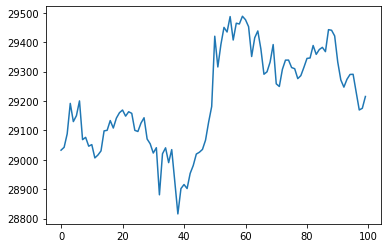

In [12]:
prepared_df[:100]['close'].plot()

<AxesSubplot:>

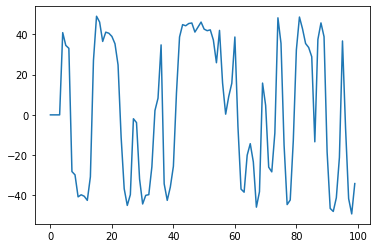

In [13]:
prepared_df[:100]['slope'].plot()

<AxesSubplot:>

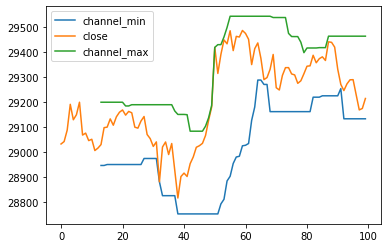

In [14]:
prepared_df[:100][{'channel_max', 'channel_min', 'close'}].plot()

<AxesSubplot:>

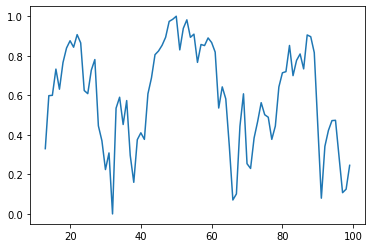

In [15]:
prepared_df[:100]['position_in_channel'].plot()

## Some plots

    index      date      open      high       low     close  volume  \
0     100  20210101  29215.00  29224.88  29208.26  29223.09      53   
1     101  20210101  29218.97  29250.00  29212.94  29224.97      65   
2     102  20210101  29224.97  29251.58  29200.00  29204.00      54   
3     103  20210101  29204.00  29270.69  29176.41  29258.51      51   
4     104  20210101  29258.51  29268.01  29213.31  29240.21      56   
..    ...       ...       ...       ...       ...       ...     ...   
95    195  20210101  29466.19  29500.87  29423.35  29432.88      34   
96    196  20210101  29431.28  29454.98  29383.23  29423.89      48   
97    197  20210101  29423.89  29475.78  29402.64  29472.13      31   
98    198  20210101  29471.78  29502.86  29460.45  29473.70      32   
99    199  20210101  29475.69  29492.57  29438.70  29488.89      29   

        slope  channel_max  channel_min  position_in_channel islmin islmax  
0   12.289902     29465.00     29133.53             0.270190  False  F

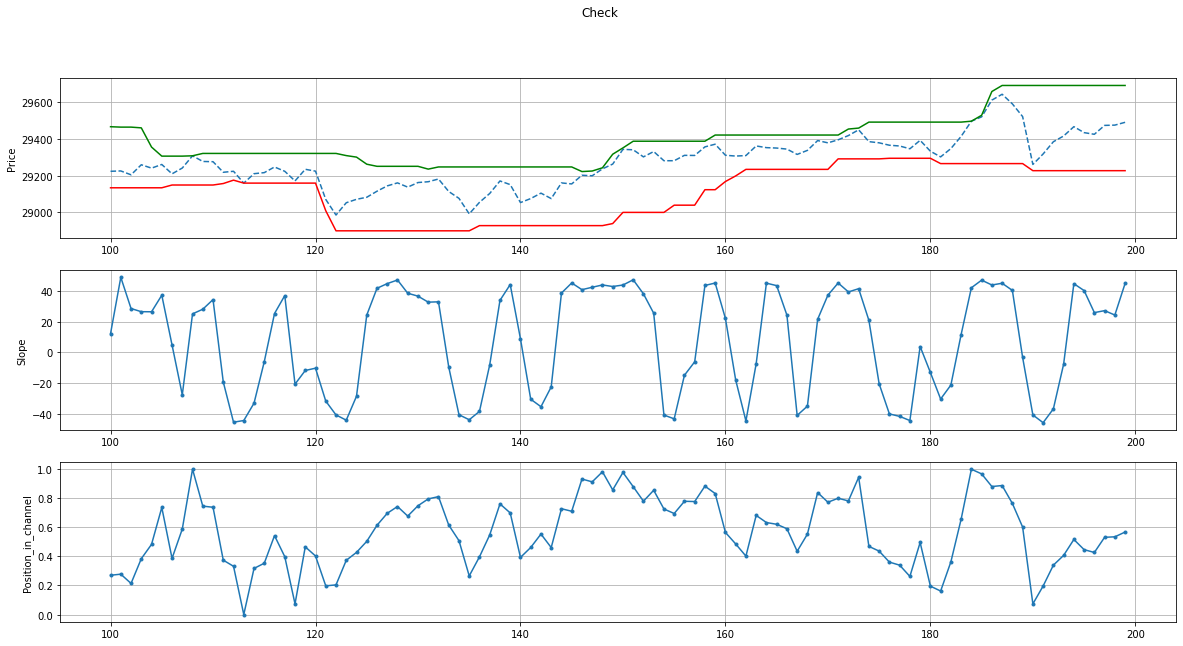

In [16]:
small_df = prepared_df[100:200]
small_df = small_df.reset_index()
print(small_df)

fig, (ax1, ax2,ax3) = plt.subplots(3, 1)
fig.suptitle('Check')
fig.set_size_inches(20, 10)
x = small_df['index']

labels = {"close" : "--", "channel_max" : "g-", "channel_min" : "r-"}
for label in labels:
    ax1.plot(x, small_df[label], labels[label])

ax1.set_ylabel('Price')
ax1.grid(True)

ax2.plot(x, small_df['slope'], '.-')
ax2.set_ylabel('Slope')
ax2.grid(True)

ax3.plot(x, small_df['position_in_channel'], '.-')
ax3.set_ylabel("Position_in_channel")
ax3.grid(True)

plt.show()


# Testing strategy

In [17]:
stop_loss = 0.1
btc_profits_array = [[1, 0.005], [2, 0.01], [2, 0.015], [3, 0.02], [2, 0.025], [0, 0.03]]

def testing_strategy(prepared_df, stop_loss, profit_coefs):
    
    position=0
    total_earn = 0
    df_len = len(prepared_df)

    print('start')

    for i in range(4, df_len-1):
        if position>0:
        # have long
            if(prepared_df['close'][i]<stop_price):
                # stop loss
                print(i, 'long stop loss')
                total_earn -= (open_price - prepared_df['close'][i]) * position
                position = 0
            else:
                # maybe close position 
                while profits_array[current_profit_pos][1] <= prepared_df['close'][i] and position > 0:
                    print(i, 'long earn')
                    position -= profits_array[current_profit_pos][0]
                    total_earn += profits_array[current_profit_pos][0] * (prepared_df['close'][i] - open_price)
                    current_profit_pos += 1

        elif position<0:
        # have hort
            if(prepared_df['close'][i]>stop_price):
                # stop loss
                print(i, 'short stop loss')
                total_earn += (prepared_df['close'][i]-open_price) * position
                position=0
            else:
                # maybe close position
                while profits_array[current_profit_pos][1] >= prepared_df['close'][i] and position < 0:
                    print(i, 'short earn')
                    position += profits_array[current_profit_pos][0]
                    total_earn -= profits_array[current_profit_pos][0] * (prepared_df['close'][i] - open_price)
                    current_profit_pos += 1
        else:
            if(prepared_df['islmin'][i-1]):
                # open long
                if(prepared_df['position_in_channel'][i-1]<0.3 and prepared_df['slope'][i-1])<-5:
                    print(i, 'open long')
                    profits_array=list()
                    current_profit_pos = 0
                    open_price = prepared_df['close'][i]
                    stop_price = prepared_df['close'][i] * (1 - stop_loss)
                    for pr in profit_coefs:
                        profits_array.append([pr[0], (1 + pr[1]) * open_price])
                    position = 10
            if(prepared_df['islmax'][i-1]):
                # open short
                if(prepared_df['position_in_channel'][i-1]>0.7 and (prepared_df['slope'][i-1])>5):
                    print(i, 'open short')
                    profits_array=list()
                    current_profit_pos = 0
                    open_price=prepared_df['close'][i]
                    stop_price=prepared_df['close'][i]*(1 + stop_loss)
                    for pr in profit_coefs:
                        profits_array.append([pr[0], (1 - pr[1]) * open_price])
                    position = -10
    return total_earn

In [18]:
stop_loss = 0.1
btc_profits_array = [[1, 0.005], [2, 0.01], [3, 0.015], [2, 0.02], [2, 0.025], [0, 0.03]]

current_earn = testing_strategy(prepared_df, stop_loss, btc_profits_array)

start
21 open short
32 short earn
38 short earn
517 short stop loss
524 open short
525 short earn
525 short earn
568 short earn
571 short earn
573 short earn
576 open long
579 long earn
579 long earn
592 long earn
593 long earn
618 long earn
624 open short
988 short earn
988 short earn
1004 short earn
1010 short earn
1013 short earn
1033 open short
1406 short stop loss
1408 open short
1760 short stop loss
1764 open short
1863 short earn
2179 short stop loss
2182 open short
2238 short earn
2238 short earn
2279 short earn
2293 short earn
2298 short earn
2302 open long
2311 long earn
2315 long earn
2322 long earn
2322 long earn
2323 long earn
2329 open short
2348 short earn
2353 short earn
2355 short earn
2406 short earn
2410 short earn
2419 open long
2430 long earn
2437 long earn
2443 long earn
2445 long earn
2448 long earn
2452 open short
2454 short earn
2460 short earn
2764 short earn
2764 short earn
2764 short earn
2791 open short
2796 short earn
2806 short earn
2808 short earn
2833 s

In [19]:
print(current_earn)

208260.17999999982
